## 序列模型

### 序列数据
* 实际中很多数据是有时序结构的
* 电影的评价随时间变化而变化
    * 拿奖后评分上升，直到奖项被忘记
    * 看了很多好电影后，人们的期望变高
    * 季节性：贺岁片、暑期档
    * 导演、演员的负面报道导致评分变低
    * ...


### 统计工具
* 在时间t观察到$x_t$，那么得到T个不独立的随机变量
$$
(x_1, ..., x_T) \sim p(x)
$$
* 使用条件概率展开
$$
p(a, b) = p(a)p(b|a) = p(b)p(a|b)
$$
展开的大一点
$$
p(x) = p(x_1)p(x_2 | x_1)p(x_3|x_1, x_2)...p(x_T|x_1, ..., x_{T-1})
$$
反过来也可以展开，但是物理上不一定可行
### 序列模型
$$
p(x) = p(x_1)p(x_2 | x_1)p(x_3|x_1, x_2)...p(x_T|x_1, ..., x_{T-1})
$$
* 对条件概率建模
$$
p(x_t| x_1, x_2, ..., x_{t - 1}) = p(x_t | f(x_1, ..., x_{t - 1}))
$$
对见过的数据建模，也称`自回归模型`

#### 方案A——Markov假设
* 假设当前数据只跟$\tau$个过去数据点相关
$$
p(x_t | x_1, ..., x_{t - 1}) = p(x_t | x_{t - \tau}, ..., x_{t - 1}) = p(x_t| f(x_{t - \tau}, ..., x_{t - 1}))
$$
例如在过去数据上训练一个MLP模型

#### 潜变量
* 引入浅$h_t$来表示过去信息$h_t = f(x_1, ..., x_{t - 1})$
    * 这样$x_t = p(x_t | h_t)$

summary
* 时序模型中，当前数据跟之前观察到的数据相关
* 自回归模型使用自身过去数据来预测未来
* Markov模型假设当前值跟最近少数数据相关，从而简化模型
* 浅变量模型使用潜变量来概括历史信息


### 代码

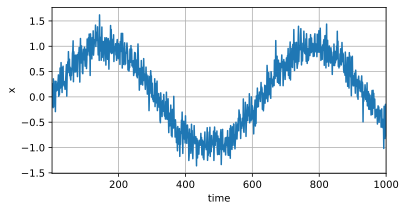

In [3]:
# 序列模型
# 使用正弦函数和一些可加性噪声生成序列数据，时间步为1,2,...，1000
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [4]:
# 将数据映射为数据对y_t = x_t和x_t = [x_{t - \tau}, ..., x_{t - 1}]

tau = 4 # 我们的模型假设每一个时间步的x只和过去的4个时间步有关
features = torch.zeros((T - tau, tau))

for i in range(tau):
    features[:, i] = x[i: T - tau + i]

labels = x[tau: ].reshape((-1, 1))

batch_size, n_train = 16, 600

train_iter = d2l.load_array(
    (features[: n_train], labels[: n_train]),
    batch_size, is_train=True
)

In [5]:
# 使用一个简单的结构：只是一个拥有两个全连接层的MLP

def init_wieghts(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10), nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_wieghts)
    return net

loss = nn.MSELoss()


In [6]:
# 训练模型

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(
            f'epoch {epoch + 1}, ',
            f'loss: {d2l.evaluate_loss(net, train_iter, loss)}'
        )

net = get_net()
train(net, train_iter, loss, 5, 0.01)


epoch 1,  loss: 0.06113108865132457
epoch 2,  loss: 0.05122019375037206
epoch 3,  loss: 0.05006650389221154
epoch 4,  loss: 0.04764069131526508
epoch 5,  loss: 0.046944392158796915


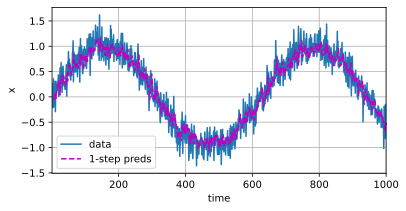

In [7]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],
    'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)

TypeError: len() of a 0-d tensor

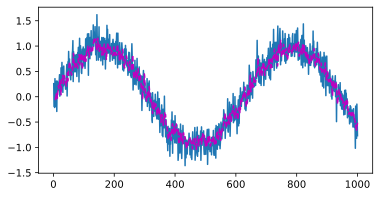

In [8]:
# 进行多步预测

multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau: i].reshape((1, -1)))

d2l.plot(
    [time, time[tau: ], time[n_train + tau]],
    [
        x.detach().numpy(), 
        onestep_preds.detach().numpy(), 
        multistep_preds.detach().numpy()    
    ],
    'time', 'x', legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3)
)

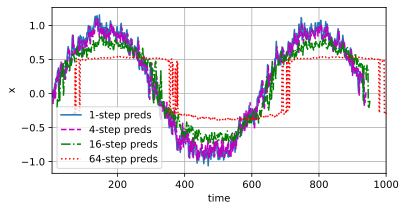

In [11]:
# 在仔细看一下k步预测

max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau: i]).reshape(-1)

steps = (1, 4, 16, 64)

d2l.plot(
    [time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps],
    'time', 'x', legend=[f'{i}-step preds' for i in steps],
    xlim=[5, 1000], figsize=(6, 3)
)

## 文本预处理

### 代码实现


In [14]:
import collections
import re # 正则表达式的module
from d2l import torch as d2l


# 将数据集读取到由多条文本组成的列表中

def read_time_machine():
    '''Load the time machine dataset into a list of text lines'''
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    # 实际使用中不会用这么暴力的预处理
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()

print(f'text lines: {len(lines)}')
print(lines[0])
print(lines[10])


text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [18]:
# 每个文本序列又被拆分成一个标记列表

def tokenize(lines, token='word'):
    '''将文本行拆分成单词或字符进行标记'''
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('Error')

tokens = toeknize(lines)
for i in range(11):
    print(tokens[i])


# 构建一个字典，通常叫做词汇表vocabulary，用来将字符串类型的标记映射到从0开始的数字索引中

class Vocab:
    '''文本词汇表'''
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self.token_freqs = sorted(
            counter.items(), key=lambda x: x[1], reverse=True
        )
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        # unk是一个常见的表示，意思是unknown

        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens
        ]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_token(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):
    '''统计标记的频率'''
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [19]:
# 构建词汇表
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[: 10])

# 将每一行文本行转换成一个数字索引列表
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

# 将所有功能打包到load_corpus_time_machine函数种
def load_corpus_time_machine(max_tokens=-1):
    '''返回时光机器数据集的标记索引列表和词汇表'''
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # corpus语料库： a collection of written or spoken material stored on a computer and used to find out how language is used
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[: max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)


[('<unk>', 1), ('the', 2), ('i', 3), ('and', 4), ('of', 5), ('a', 6), ('to', 7), ('was', 8), ('in', 9), ('that', 10)]
words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [2, 20, 51, 41, 2184, 2185, 401]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2187, 4, 26, 1045, 363, 114, 8, 1422, 4, 1046, 2]


(170580, 28)

## 语言模型
* 给定文本序列$x_1, ..., x_T$，语言模型的目标是估计联合概率$p(x_1, ..., x_T)$
* 它的应用包括：
    * 做预训练模型(BERT, GPT-3等)
    * 做文本生成，给定前几个词，不断使用$x_t \sim p(x_t|x_1, ..., x_{t -1})$来生成后续文本
    * 判断多个序列中哪个更常见

### 使用计数来建模
* 假设序列长度为2,预测
$$
p(x, x') = p(x)p(x'|x) = \frac{n(x)}{n} \frac{x(x, x')}{n(x)}
$$
这里n是总词数，$n(x), n(x, x')$是单个单词和连续单词对的出现次数
* 很容易拓展到长为3的情况
$$
p(x, x', x'') = p(x)p(x'|x)p(x''|x, x') = \frac{n(x)}{n} \frac{n(x, x')}{n(x)} \frac{n(x, x', x'')}{n(x, x')}
$$
### N元语法
* 当序列很长时，因为文本量不够大，很可能$n(x_1, ..., x_T) \le 1$
* 使用Markov假设来缓解这个问题：

* 一元语法
$$
p(x_1, x_2, x_3, x_4) = p(x_1)p(x_2)p(x_3)p(x_4) = \frac{n(x_1)}{n} \frac{n(x_2)}{n} \frac{n(x_3)}{n} \frac{n(x_4)}{n}
$$
* 二元语法
$$
p(x_1, x_2, x_3, x_4) = p(x_1)p(x_2 | x_1)p(x_3|x_2)p(x_4|x_3) = \frac{n(x_1)}{n} \frac{n(x_1, x_2)}{n(x_1)} \frac{n(x_2, x_3)}{n(x_2)} \frac{n(x_3, x_4)}{n(x_3)}
$$
* 三元语法
$$
p(x_1, x_2, x_3, x_4) = p(x_1)p(x_2 | x_1)p(x_3 | x_1, x_2)p(x_4 | x_1, x_2, x_3)
$$

### 代码——语言模型和数据集

[(('e', ' '), 6037), ((' ', 't'), 5138), (('t', 'h'), 4616), (('h', 'e'), 3859), (('d', ' '), 3825), ((' ', 'a'), 3581), (('t', ' '), 3251), (('i', 'n'), 2935), (('s', ' '), 2910), ((' ', 'i'), 2722)]
[((' ', 't', 'h'), 3629), (('t', 'h', 'e'), 3127), (('h', 'e', ' '), 2205), (('n', 'd', ' '), 1483), (('a', 'n', 'd'), 1399), ((' ', 'a', 'n'), 1368), (('e', 'd', ' '), 1352), ((' ', 'o', 'f'), 1126), (('i', 'n', 'g'), 1101), ((' ', 'i', ' '), 1075)]


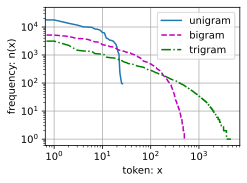

In [21]:
import random
import torch 
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
corpus = [token for line in lines for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[: 10]


# 最流行的词，被称为`停用词`，画出词频图
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(
    freqs, xlabel='token: x', ylabel='frequency: n(x)',
    yscale='log'
)

# 其他的词元组合，比如二元语法，三元语法
bigram_tokens = [
    pair for pair in zip(corpus[: -1], corpus[1:])
]
bigram_vocab = d2l.Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[: 10])

trigram_tokens = [
    triple for triple in 
    zip(corpus[: -2], corpus[1: -1], corpus[2:])
]
trigram_vocab = d2l.Vocab(trigram_tokens)
print(trigram_vocab.token_freqs[: 10])

# 直观的对比三种模型中的标记频率
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [22]:
# 随机的生成一个小批量数据的特征和标签以供读取。
# 在随机采样中，每个样本都是在原始的长序列上任意捕捉的字序列

def seq_data_iter_random(corpus, batch_size, num_steps):
    '''使用随机抽样生成一个小批量子序列'''
    corpus = corpus[random.randint(0, num_steps - 1):]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
    

In [23]:
# 比如说生成一个0～34的序列

my_seq = list(range(35))
for X, y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}, y: {y}')


X: tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]]), y: tensor([[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]])
X: tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17]]), y: tensor([[19, 20, 21, 22, 23],
        [14, 15, 16, 17, 18]])
X: tensor([[23, 24, 25, 26, 27],
        [28, 29, 30, 31, 32]]), y: tensor([[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]])


In [26]:
# 保证两个相邻的小批量的子序列在原始序列上也是相邻的

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    '''使用顺序分区生成一个小批量子序列'''
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [27]:
# 读取每个小批量的子序列的特征X和标签Y

for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}, Y: {Y}')

X: tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]), Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X: tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]), Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X: tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]), Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [28]:
# 将上面的两个采样函数包装到一个类中

class SeqDataLoader:
    '''加载序列数据的迭代器'''
    def __init__(self, batch_size, num_steps,
                 use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [29]:
# 最后定义一个函数load_data_time_machine，同时返回数据迭代器和词汇表

def load_data_time_machine(batch_size, num_steps,
                            use_random_iter=False, max_tokens=10000):
    '''返回时光机器数据集的迭代器和词汇表'''
    data_iter = SeqDataLoader(batch_size, num_steps, 
                            use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## Recurrent NN 循环神经网络

### 潜变量回归模型
* 使用潜变量(latent variable)$h_t$总结过去信息
$$
p(h_t | h_{t - 1}, x_{t - 1})\\
p(x_t | h_t, x_{t - 1})
$$

* hidden variable是现实世界中真实存在的问题，只是观察不到
* latent variable可以用来指代现实生活中不存在的东西

### 循环神经网络
* 更新隐藏状态：$ h_t = \phi (W_{hh}h_{t - 1} + W_{hx}x_{t - 1} + b_h $
    * 如果去掉其中的$W_{hh$h_{t - 1}$就退化成呢各MLP
* 输出：$o_t = \phi (W_{ho}h_t + b_o)$
![rnn](./imgs/rnn.png)

#### 使用循环神经网络的语言模型

### 困惑度(perplexity)
* 衡量一个语言模型的好坏可以用平均交叉熵
$$
\pi = \frac{1}{n}\Sigma_{i = 1}^n -logp(x_t | x_{t - 1}, ...)
$$
p是语言模型的预测概率，$x_t$是真实词
* 历史原因NLP使用困惑度$exp(\pi)$来衡量，是平均每次可能选项
    * 1表示完美，无穷大是最差情况

### 梯度裁减
* 迭代中计算这T个时间步上的梯度，在反向传播过程中产生长度为O(T)的矩阵乘法链，导致数值不稳定
* 梯度裁减能有效预防梯度爆炸
    * 如果梯度长度超过$\theta$，那么拖影回长度$\theta$
$$
g \leftarrow min(1, \frac{\theta}{||g||})g
$$

### 更多应用
* 文本生成
* 文本分类
* 问答、机器翻译
* Tag生成

### RNN代码实现

In [47]:
import math
import torch
from torch import nn
from torch.nn import functional as F 
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


In [48]:
# One-hot encoding独热编码

F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [49]:
# 小批量数据形状是(批量大小，时间步数)
X = torch.arange(10).reshape((2, 5))
A = F.one_hot(X.T, 28)
A.shape, A

(torch.Size([5, 2, 28]),
 tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],


In [83]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [85]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [86]:
# 下面的rnn函数定义了如何在一个时间步内计算隐藏状态和输出
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [88]:
# 创建一个类来包装这些函数

class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [89]:
# 检查输出是否具有正确的形状

num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [90]:
# 首先定义预测函数来生成prefix之后的新字符
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller', 10, net, vocab, device=d2l.try_gpu())
    
    

'time travellerkdpeihjfkh'

In [91]:
# 做梯度裁减
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [92]:
# 定义一个函数在一个迭代周期内训练模型
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [93]:
# 循环神经网络模型的训练既支持从0开始实现，也可以使用高级API进行实现

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
    

困惑度 1.0, 93012.1 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


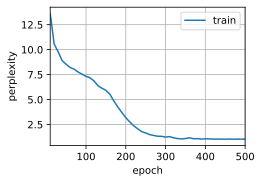

In [94]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.3, 88944.2 词元/秒 cpu
time travellerit s against reason said filbycan a cube that does
traveller ofrecatson this time and any of the three dimensi


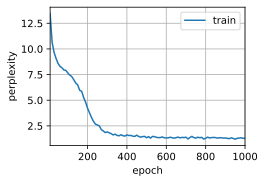

In [97]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs=1000, device=d2l.try_gpu(),
          use_random_iter=True)

### 简洁实现

In [98]:
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [99]:
# 定义模型

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [100]:
# 使用张量来初始化隐藏状态

state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [102]:
# 通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出

X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [104]:
# 为一个完整的循环神经网络模型定义了一个RNNModel类

class RNNModel(nn.Module):
    '''循环神经网络模型'''
    def __init__(self, rnn_layer, vocab_size, **kwargs) -> None:
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(
                self.num_hiddens, self.vocab_size
            )
        else:
            self.num_directions = 2
            self.linear = nn.Linear(
                self.num_hiddens * 2, self.vocab_size
            )


    def forward(self, inputs, state):
        X = F.one_hot(input.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros(
                (
                    self.num_directions * self.rnn.num_layers, 
                    batch_size,
                    self.num_hiddens
                ), device=device
            )
        else:
            # nn.LSTM以元组作为隐状态
            return (
                torch.zeros(
                    (
                        self.num_directions * self.rnn.num_layer,
                        batch_size, self.num_hiddens
                    ),
                    device=device
                ),
                torch.zeros(
                    (
                        self.num_directions * self.rnn.num_layer,
                        batch_size, self.num_hiddens
                    ),
                    device=device
                )
            )

perplexity 1.0, 91333.6 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


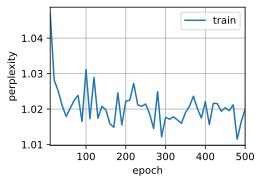

In [105]:
# 使用高级API训练模型

num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device=d2l.try_gpu())

## 门控循环单元GRU
* 什么叫门空gated
### 关注一个序列
* 不是每个观察值都是同等重要
* 想只记住相关的观察需要
    * 能关注的机制(更新门)
    * 能遗忘的机制(重置门)
![gru](./imgs/gru_1.png)


### 门
$$
R_t = \sigma (X_t W_{xr} + H_{t - 1} W_{hr} + b_r)\\
Z_t = \sigma (X_t W_{xz} + H_{t - 1} W_{hz} + b_z)
$$
![gate](./imgs/gate.png)

### 候选隐状态
$$
\tilde {H}_t = tanh(X_t W_{xh} + (R_t * H_{t - 1})W_{hh} + b_h)
$$

![candidate hidden state](./imgs/candidate_hidden_state.png)

### 隐状态

$$
H_t = Z_t * H_{t - 1} + (1 - Z_t) * \tilde{H}_t
$$
![hidden state](./imgs/hidden_state.png)

### 代码实现


In [8]:
# GRU
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [13]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [14]:
# 定义隐藏状态的初始化函数
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [15]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 53829.5 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


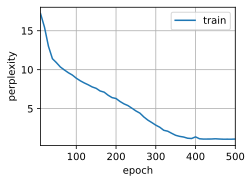

In [16]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 64790.2 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
traveller fired foweing that in time as we move about in th


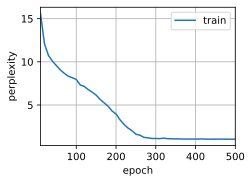

In [17]:
# 简洁实现

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab,
              lr, num_epochs, device)

## LSTM 长短期记忆网络

### 门
* 忘记门：将值朝0减少
* 输入门：决定是否忽略掉输入数据
* 输出门：决定是否适用隐状态

$$
I_t = \sigma (X_t W_xi + H_{t - 1}W_hi + b_i)\\
F_t = \sigma (X_t W_xf + H_{t - 1}W_hf + b_f)\\
O_t = \sigma (X_t W_xo + H_{t - 1}W_ho + b_o)
$$
![LSTM gate](./imgs/LSTM_gate_1.png)

### 候选记忆单元
$$
\tilde{C}_t = tanh(X_tW_{xc} + H_{t - 1}W_{hc} + b_c)
$$
![candidate memory unit](./imgs/candidate_memory_unit.png)

### 记忆单元
$$
C_t = F_t * C_{t - 1} + I_t * \tilde{C}_t
$$
![memory unit](./imgs/memory_unit.png)

### 隐状态
$$
H_t = O_t * tanh(C_t)
$$

![lstm hidden state](./imgs/LSTM_hidden_state.png)


### 代码实现

In [18]:
import torch
from torch import nn
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [21]:
# 初始化模型参数】


def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )
        
    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [
        W_xi, W_hi, b_i,
        W_xf, W_hf, b_f,
        W_xo, W_ho, b_o,
        W_xc, W_hc, b_c,
        W_hq, b_q
    ]
    for param in params:
        param.requires_grad_(True)
    return params

In [22]:
# 初始化函数

def init_lstm_state(batch_size, num_hiddens, device):
    return (
        # H
        torch.zeros((batch_size, num_hiddens), device=device),
        # candidate memory unit
        torch.zeros((batch_size, num_hiddens), device=device)
    )

In [23]:
# 模型

def lstm(inputs, state, params):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q= params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 43027.2 tokens/sec on cpu
time traveller weth a suld in a mofilato castine as a about main
traveller whith a slight accession ofcheerfulness really th


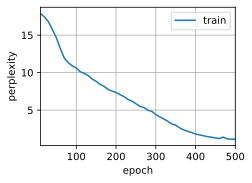

In [24]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(
    vocab_size, num_hiddens, device, 
    get_lstm_params, init_lstm_state, lstm
)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)


perplexity 1.1, 55792.0 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


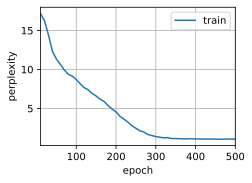

In [25]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, vocab_size)
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 深度循环神经网络 Deep RNN
* 序列长不叫深度，深度深才叫深度

### 从RNN中得到更多的非线性——更深
![deep RNN](./imgs/deep_rnn.png)

$$
H_t^1 = f_1(H_{t - 1}^1, X_t)\\
...\\
H_t^j = f_j(H_{t - 1}^j, H_t^{j - 1})\\
...\\
O_t = g(H_t^L)
$$
* 使用多个隐藏层来获得更多的非线性性】

### 代码实现


In [26]:
import torch
from torch import nn
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [27]:
# 通过num_layers的值来设定隐藏层数

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)


perplexity 1.0, 27350.3 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


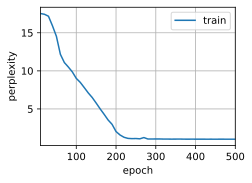

In [28]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 双向循环神经网络 Bidirectional Recurrent Neural Network(BiRNN)

### 未来很重要
* 取决于过去和未来的上下文，可以填写很不一样的词
* 目前为止RNN只看过去
* 在填空的时候，我们也可以看未来


### BiRNN
![BiRNN](./imgs/BiRNN.png)

* 一个前向RNN隐层
* 一个反向RNN隐层
* 合并两个隐状态得到输出

$$
\overrightarrow{H}_t = \phi (X_t W_{xh}^{(f)} + \overrightarrow{H}_{t - 1} W_{hh}^{(f)} + b_h^{(f)})\\

\overleftarrow{H}_t = \phi (X_t W_{xh}^{(b)} + \overleftarrow{H}_{t - 1} W_{hh}^{(b)} + b_h^{(b)})\\

H_t = [\overrightarrow{H}_t, \overleftarrow{H}_t]\\

O_t = H_t W_{hq} + b_q

$$

### 推理
![inference](./imgs/inference.png)
* BiRNN几乎不能用来做推理
* 主要用于对一个句子做特征提取

summary
* 双向神经网络通过反向更新的隐藏层来利用方向时间信息
* 通常用来对序列提取特征、填空，而不是预测未来


### 代码实现

perplexity 1.1, 11718.7 tokens/sec on cpu
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


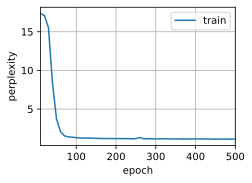

In [29]:
import torch
from torch import nn
from d2l import torch as d2l


# 双向RNN的错误运用，其实是不能用的，以为语言模型大部分都是预测未来的
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, vocab_size)
model = model.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 机器翻译数据集

In [30]:
import os
import torch 
from d2l import torch as d2l

d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    '''载入英语——法语数据集'''
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()
    
raw_text = read_data_nmt()
print(raw_text[: 75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [ ]:
# 预处理

def preprocess_nmt(text):
    '''预处理'''
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    text = text.replace()